In [21]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [22]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [23]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [24]:
def bonos_dbAlgebra(n,cn):

    niu_data = pd.DataFrame()

    bonos = "SELECT TOP ("+ str(n) +") Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, NemotecnicoBono AS Nemotecnico, RiesgoInt FROM (SELECT * FROM (SELECT Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, Nemotecnico AS NemotecnicoBono FROM [dbAlgebra].[dbo].[TdNemoRF]) AS bono JOIN (SELECT * FROM [dbPortFolio].[dbo].[TdPlanvitalCartera]) AS planvital ON bono.FechaEmision > '20190101' AND bono.NemotecnicoBono = planvital.Nemotecnico) AS A JOIN (SELECT DISTINCT Nemotecnico, RiesgoLVA AS RiesgoInt FROM [dbAlgebra].[dbo].[TdRiesgoLva]) AS B ON A.NemotecnicoBono = B.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)

    moneda = []
    base1 = []
    base2 = []
    tabla = []
    fechaemi = []
    nemotecnico = []
    riesgo = []
    for i in range(np.size(bonos, 0)):

        if bonos["Nemotecnico"][i] in nemotecnico: continue

        if bonos["RiesgoInt"][i] in riesgo : continue

        moneda.append(bonos["Moneda"][i])
        base1.append(bonos["Base1"][i])
        base2.append(bonos["Base2"][i])
        tabla.append(bonos["TablaDesarrollo"][i])
        fechaemi.append(bonos["FechaEmision"][i])
        nemotecnico.append(bonos["Nemotecnico"][i])
        riesgo.append(bonos["RiesgoInt"][i])

    niu_data["Moneda"] = moneda
    niu_data["Base1"] = base1
    niu_data["Base2"] = base2
    niu_data["TablaDesarrollo"] = tabla
    niu_data["FechaEmision"] = fechaemi
    niu_data["Nemotecnico"] = nemotecnico
    niu_data["RiesgoInt"] = riesgo


    return niu_data

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [25]:
def conversionSYP(riesgo):
    return {-1: "AAA", 1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [26]:
bonos = ajustes(bonos_dbAlgebra(500,cn))
bonos

,Moneda,Base1,Base2,TablaDesarrollo,FechaEmision,Nemotecnico,RiesgoInt,Convencion,Riesgo
0,UF,ACT,365,"1#01-08-2019#1,25#0#100#1,25|2#01-02-2020#1,25...",2019-02-01,BBIC750219,3,ACT/365,AA
1,UF,ACT,365,"1#01-03-2020#0,3245#0#100#0,3245|2#01-09-2020#...",2019-09-01,BCSSA-C,2,ACT/365,AA
2,UF,ACT,365,"1#01-09-2019#1,3163#0#100#1,3163|2#01-03-2020#...",2019-03-01,BFFCC-AD,1,ACT/365,AAA
3,UF,ACT,365,"1#30-10-2019#1,094#0#100#1,094|2#30-04-2020#1,...",2019-04-30,BVIAS-A,4,ACT/365,AA
4,UF,ACT,365,"1#01-12-2019#0,8464#0#100#0,8464|2#01-06-2020#...",2019-06-01,BCMPC-O,-1,ACT/365,AAA
5,UF,ACT,365,"1#15-10-2019#1,7841#0#100#1,7841|2#15-04-2020#...",2019-04-15,BLATM-E,8,ACT/365,BBB


In [27]:
bonos["Riesgo"].values

array(['AA', 'AA', 'AAA', 'AA', 'AAA', 'BBB'], dtype=object)

In [28]:
derivados = derivados_dBDerivados(1, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

C:\Users\Lenovo\Documents\Universidad\lvaindices-reporte-indicadores\Cartera\DerivadosTipos\DerivadosSCC.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_cartera.MonedaActivo[0] = "CLP"


,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [29]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "DE000DWS2D90", "ANTARCHILE"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)
acciones


,Moneda,Nombre,Nemotecnico,Inversion,Historico
0,CLP,AESGENER,AESGENER,1.711040e+09,"[[0, 0.0025957870479299534, -0.007433469137058..."
1,CLP,AGUAS-A,AGUAS-A,1.531281e+07,"[[0, 0.003305297208302039, 0.03566773260328181..."
2,CLP,ANDINA-A,ANDINA-A,1.492768e+08,"[[0, 0.00034804011961498776, 0.018505998119275..."
3,CLP,ANDINA-B,ANDINA-B,1.073699e+09,"[[0, 0.005746838657845234, 0.0175731917247771,..."
4,CLP,DE000DWS2D90,DE000DWS2D90,1.194112e+10,"[[0, -0.011984448831005957, -0.025391621016988..."
5,CLP,ANTARCHILE,ANTARCHILE,1.511532e+08,"[[0, 0.009876696995043567, 0.00310408270978682..."


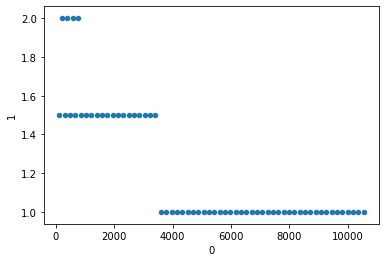

In [30]:
cartera = Cartera(acciones, bonos.head(3), derivados, "CLP", datetime.date(2019, 10, 14), cn)

In [31]:
cartera.get_diccionario_niveles()

{1: {('Renta Variable Nacional Acciones',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.51153165e+08]),
  ('Renta Variable Extranjera',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.19411228e+10, 0.00000000e+00]),
  ('Renta Fija Nacional ',
   'Bono',
   'AA'): array([1.04317445e+00, 7.86199761e-01, 1.22189122e-01, 5.09498038e-01,
         6.01183048e-02, 3.06847935e-01, 3.48173184e-02, 1.74493358e-01,
         8.58352028e-02, 2.77868316e-02, 1.23880738e-02, 2.95795354e-02,
         1.22251418e-02, 4.61209382e-03, 2.07410578e-03, 1.02000583e-03,
         5.16258669e-04, 2.55747371e-04, 1.29640088e-04, 6.42287266e-05,
         3.25602501e-05, 1.61793667e-05, 9.47685591e-05, 1.79063277e-04,
         1.56541886e-05, 6.12393914e-05, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00,

In [32]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.008285051656819243


In [33]:
cartera.get_covarianza()

,CLP#123#AA,CLP#209#AA,CLP#304#AA,CLP#390#AA,CLP#484#AA,CLP#569#AA,CLP#664#AA,CLP#750#AA,CLP#844#AA,CLP#1024#AA,...,CLP#9864,CLP#10045,CLP#10224,CLP#10406,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#123#AA,9.186873e-06,0.000017,0.000027,0.000037,0.000046,0.000054,0.000062,0.000068,0.000070,0.000071,...,-4.160136e-07,-4.237110e-07,-4.313233e-07,-4.390632e-07,0.000010,-0.000002,-0.000004,-0.000014,-4.262687e-07,-0.000008
CLP#209#AA,1.686452e-05,0.000031,0.000051,0.000070,0.000086,0.000100,0.000114,0.000124,0.000128,0.000127,...,-1.203149e-06,-1.225371e-06,-1.247348e-06,-1.269693e-06,0.000018,-0.000002,-0.000007,-0.000026,-1.029760e-06,-0.000014
CLP#304#AA,2.716243e-05,0.000051,0.000084,0.000116,0.000141,0.000162,0.000184,0.000198,0.000203,0.000199,...,-2.690830e-06,-2.740468e-06,-2.789558e-06,-2.839471e-06,0.000030,-0.000003,-0.000012,-0.000041,-2.135081e-06,-0.000024
CLP#390#AA,3.722136e-05,0.000070,0.000116,0.000161,0.000195,0.000223,0.000252,0.000270,0.000276,0.000269,...,-4.127270e-06,-4.203366e-06,-4.278622e-06,-4.355138e-06,0.000041,-0.000003,-0.000016,-0.000056,-3.231788e-06,-0.000033
CLP#484#AA,4.594610e-05,0.000086,0.000141,0.000195,0.000237,0.000274,0.000312,0.000337,0.000346,0.000340,...,-4.310654e-06,-4.390126e-06,-4.468719e-06,-4.548630e-06,0.000050,-0.000004,-0.000018,-0.000069,-3.414835e-06,-0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,-1.595777e-06,-0.000002,-0.000003,-0.000003,-0.000004,-0.000006,-0.000008,-0.000009,-0.000010,-0.000010,...,-2.790399e-05,-2.841604e-05,-2.892244e-05,-2.943733e-05,-0.000012,0.000100,0.000039,0.000058,1.555668e-05,0.000037
ANDINA-A,-3.573957e-06,-0.000007,-0.000012,-0.000016,-0.000018,-0.000020,-0.000021,-0.000022,-0.000025,-0.000030,...,-1.784621e-06,-1.818287e-06,-1.851582e-06,-1.885435e-06,0.000015,0.000039,0.000418,0.000084,5.061778e-05,0.000085
ANDINA-B,-1.443430e-05,-0.000026,-0.000041,-0.000056,-0.000069,-0.000080,-0.000092,-0.000101,-0.000108,-0.000116,...,-8.363278e-05,-8.516662e-05,-8.668352e-05,-8.822583e-05,-0.000003,0.000058,0.000084,0.000433,8.275641e-06,0.000084
DE000DWS2D90,-4.262687e-07,-0.000001,-0.000002,-0.000003,-0.000003,-0.000003,-0.000003,-0.000002,-0.000002,-0.000002,...,-1.321168e-05,-1.345570e-05,-1.369703e-05,-1.394241e-05,-0.000006,0.000016,0.000051,0.000008,6.330338e-05,0.000009


In [34]:
cartera.get_correlacion()

,CLP#123#AA,CLP#209#AA,CLP#304#AA,CLP#390#AA,CLP#484#AA,CLP#569#AA,CLP#664#AA,CLP#750#AA,CLP#844#AA,CLP#1024#AA,...,CLP#9864,CLP#10045,CLP#10224,CLP#10406,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#123#AA,1.000000,0.995662,0.978919,0.968335,0.983953,0.993607,0.995658,0.989308,0.978800,0.918075,...,-0.009374,-0.009376,-0.009377,-0.009378,0.233991,-0.052665,-0.057683,-0.228879,-0.017676,-0.206628
CLP#209#AA,0.995662,1.000000,0.993610,0.987234,0.996018,0.998387,0.990991,0.977426,0.963204,0.894158,...,-0.014704,-0.014706,-0.014708,-0.014710,0.239483,-0.043599,-0.059656,-0.223022,-0.023160,-0.209554
CLP#304#AA,0.978919,0.993610,1.000000,0.998883,0.999074,0.992376,0.973352,0.950971,0.932202,0.853426,...,-0.020075,-0.020077,-0.020079,-0.020081,0.242801,-0.032029,-0.061467,-0.217423,-0.029313,-0.210080
CLP#390#AA,0.968335,0.987234,0.998883,1.000000,0.996802,0.986549,0.963002,0.937174,0.916524,0.833813,...,-0.022227,-0.022229,-0.022231,-0.022233,0.242909,-0.025514,-0.061526,-0.213988,-0.032029,-0.209095
CLP#484#AA,0.983953,0.996018,0.999074,0.996802,1.000000,0.996457,0.981456,0.961965,0.944243,0.867457,...,-0.019110,-0.019112,-0.019113,-0.019115,0.239922,-0.028786,-0.058709,-0.215580,-0.027859,-0.208374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,-0.052665,-0.043599,-0.032029,-0.025514,-0.028786,-0.032194,-0.036440,-0.039307,-0.040052,-0.041117,...,-0.190636,-0.190637,-0.190638,-0.190639,-0.088274,1.000000,0.188988,0.277994,0.195585,0.303122
ANDINA-A,-0.057683,-0.059656,-0.061467,-0.061526,-0.058709,-0.055362,-0.050499,-0.048167,-0.051731,-0.058361,...,-0.005963,-0.005966,-0.005969,-0.005971,0.056380,0.188988,1.000000,0.197562,0.311225,0.338087
ANDINA-B,-0.228879,-0.223022,-0.217423,-0.213988,-0.215580,-0.215977,-0.214371,-0.213591,-0.217713,-0.219614,...,-0.274522,-0.274521,-0.274519,-0.274518,-0.010407,0.277994,0.197562,1.000000,0.049990,0.327175
DE000DWS2D90,-0.017676,-0.023160,-0.029313,-0.032029,-0.027859,-0.023087,-0.016486,-0.011730,-0.010799,-0.008348,...,-0.113410,-0.113424,-0.113437,-0.113450,-0.060160,0.195585,0.311225,0.049990,1.000000,0.093734


In [35]:
cartera.get_volatilidad_niveles()

{1: {('Renta Variable Nacional Acciones', 'Accion'): 0.012318889593453,
  ('Renta Variable Extranjera', 'Accion'): 0.00795634184685601,
  ('Renta Fija Nacional ', 'Bono', 'AA'): 0.007350684755298424,
  ('Renta Fija Nacional ', 'Bono', 'AAA'): 0.031746157900001896,
  ('Derivados', 'Derivado'): 0.0005982491981777104},
 2: {('Acciones Electricas', 'Accion'): 0.0134479288150447,
  ('Acciones Servicios', 'Accion'): 0.00999697675731327,
  ('Acciones Industrial', 'Accion'): 0.02080684545966357,
  ('Equities Europe', 'Accion'): 0.00795634184685601,
  ('Acciones Recursos Naturales', 'Accion'): 0.012318889593453,
  ('Bonos Financieros', 'Bono', 'AA'): 0.007141080101571677,
  ('Bonos Corporativos', 'Bono', 'AAA'): 0.03171123423781147,
  ('Derivados FWD Inversión', 'Derivado'): 0.0005982491981826837}}

In [36]:
cartera.var_RI_M()

,0
AESGENER,6.964924
AGUAS-A,6.964773
ANDINA-A,6.964775
ANDINA-B,6.964750
DE000DWS2D90,6.996924
ANTARCHILE,6.964773
BBIC750219,6.964773
BCSSA-C,6.964773
BFFCC-AD,6.964773
BCINO UF 200709_A,6.964775


In [37]:
cartera.var_RI()

,0
AESGENER,0.069500
AGUAS-A,0.069648
ANDINA-A,0.069646
ANDINA-B,0.069672
DE000DWS2D90,0.038041
ANTARCHILE,0.069648
BBIC750219,0.069648
BCSSA-C,0.069648
BFFCC-AD,0.069648
BCINO UF 200709_A,0.069646


In [38]:
cartera.var_CI()

,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE,BBIC750219,BCSSA-C,BFFCC-AD,BCINO UF 200709_A
0,0.0695,0.069648,0.069646,0.069672,0.038041,0.069648,0.069648,0.069648,0.069648,0.069646


In [39]:
cartera.var_porcentual_dinero()

0.0627928438749186

In [40]:
cartera.var_i_porcentual_dinero()

,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE,BBIC750219,BCSSA-C,BFFCC-AD,BCINO UF 200709_A
0,0.014599,0.000097,0.001936,0.014174,0.06028,0.001181,1.457455e-11,4.529282e-12,2.246629e-10,0.003788


In [41]:
cartera.var_i_porcentual_dinero(cartera.get_monto())

,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE,BBIC750219,BCSSA-C,BFFCC-AD,BCINO UF 200709_A
0,3.652716e+08,2.430099e+06,4.844043e+07,3.546410e+08,1.508200e+09,2.955896e+07,0.364654,0.113322,5.621054,9.476345e+07
